In [1]:
%matplotlib inline
from __future__ import print_function, division

import csv
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.spatial.distance import jaccard
from sklearn.metrics import jaccard_similarity_score
from sklearn.preprocessing import normalize

In [2]:
def load_mallet_matrix(model_name, valid_app_ids, filename="doc_matrix.tsv", mallet_dir="mallet"):
    full_path = os.path.join(mallet_dir, model_name, filename)
    with open(full_path, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        app_ids = list()
        vectors = list()
        for line in reader:
            app_id = np.int(line[1].split("/")[-1])
            if valid_app_ids is not None and app_id not in valid_app_ids:
                continue
            app_ids.append(np.int(line[1].split("/")[-1]))
            vector = np.array(map(np.float, line[2:]))
            vector /= np.linalg.norm(vector)
            vectors.append(vector)
    app_ids, vectors = np.array(app_ids), np.array(vectors)
    app_order = np.argsort(app_ids)
    app_ids = app_ids[app_order]
    vectors = vectors[app_order]
    return app_ids, vectors

def load_doc_tag_matrix(valid_app_ids, filename="doc_tag_matrix.npy", data_dir="data"):
    with open(os.path.join(data_dir, filename), "rb") as f:
        arr = np.load(f)
    app_ids, doc_tag_matrix = arr[:, 0], arr[:, 1:]
    if valid_app_ids is not None:
        to_keep = np.array([i 
                            for i, app_id in enumerate(app_ids)
                            if app_id in valid_app_ids])
        app_ids = app_ids[to_keep]
        doc_tag_matrix = doc_tag_matrix[to_keep]
    app_order = np.argsort(app_ids)
    app_ids = app_ids[app_order]
    doc_tag_matrix = doc_tag_matrix[app_order]
    return app_ids, doc_tag_matrix

In [31]:
app_ids, descriptions_matrix = load_mallet_matrix("40_features_descriptions", None)
descriptions_matrix = normalize(descriptions_matrix)

# Some games are missing from this matrix, so we have to remove them
app_id_to_index = {app_id: i for i, app_id in enumerate(app_ids)}

_, reviews_matrix = load_mallet_matrix("40_features", app_id_to_index)
_, reviews_matrix_100 = load_mallet_matrix("100_features", app_id_to_index)
_, reviews_matrix_25_2000 = load_mallet_matrix("25_features_2000_tokens", app_id_to_index)
_, reviews_matrix_50_2000 = load_mallet_matrix("50_features_2000_tokens", app_id_to_index)
_, reviews_matrix_30_1000_2000 = load_mallet_matrix("30_features_1000_tokens_2000_iterations", app_id_to_index)
_, jaccard_matrix = load_doc_tag_matrix(app_id_to_index)

descriptions_sim = descriptions_matrix.dot(descriptions_matrix.T)
reviews_sim = reviews_matrix.dot(reviews_matrix.T)
reviews_sim_100 = reviews_matrix_100.dot(reviews_matrix_100.T)
reviews_sim_25_2000 = reviews_matrix_25_2000.dot(reviews_matrix_25_2000.T)
reviews_sim_50_2000 = reviews_matrix_50_2000.dot(reviews_matrix_50_2000.T)
reviews_sim_30_1000_2000 = reviews_matrix_30_1000_2000.dot(reviews_matrix_30_1000_2000.T)

In [8]:
jaccard_sim = jaccard_matrix.dot(jaccard_matrix.T).astype(np.float)
for app1, app2 in np.ndindex(jaccard_sim.shape):
    if app1 < app2:
        union = np.logical_or(jaccard_matrix[app1], jaccard_matrix[app2]).sum() + 1 # Smoothing
        jaccard_sim[app1, app2] /= union
        jaccard_sim[app2, app1] /= union
    elif app1 == app2:
        jaccard_sim[app1, app2] = 1.0

In [32]:
models = {
    "40_features": reviews_sim,
    "100_features": reviews_sim_100,
    "25_features_2000_tokens": reviews_sim_25_2000,
    "50_features_2000_tokens": reviews_sim_50_2000,
    "30_features_1000_tokens_2000_iterations": reviews_sim_30_1000_2000,
    "Jaccard": jaccard_sim
}

In [13]:
def get_ground_truth(app_index, ground_truth_matrix, lim=100):
    return set(np.argsort(ground_truth_matrix[app_index])[::-1][:lim])

def get_ranking(app_index, sim_matrix):
    return np.argsort(sim_matrix[app_index])[::-1]

def precision_recall(app_index, sim_matrix, ground_truth_matrix):
    # From assignment 3
    ranking_in = get_ranking(app_index, sim_matrix)
    relevant = get_ground_truth(app_index, ground_truth_matrix)
    
    precision = np.zeros(len(ranking_in) + 1)
    recall = np.zeros(len(ranking_in) + 1)
    num_relevant = len(relevant)
    
    num_rel_retrieved = 0
    for i, app_index in enumerate(ranking_in):
        i = i + 1
        if app_index in relevant:
            num_rel_retrieved += 1
        precision[i] = num_rel_retrieved / i
        recall[i] = num_rel_retrieved / num_relevant
    return precision[1:], recall[1:]

queries = {
    "Dark Souls II": app_id_to_index[211420],
    "Subnautica": app_id_to_index[264710],
    "Portal 2": app_id_to_index[620],
    "Ark: Survival Evolved": app_id_to_index[346110],
    "Borderlands 2": app_id_to_index[49520],
}

In [33]:
def plot_precision_recall(axis,
                          test_matrix, test_model_name,
                          ground_truth_matrix, ground_truth_model_name):
    title = "Precision recall for %s model using %s model as ground truth"%(test_model_name,
                                                                            ground_truth_model_name)
    axis.set_title(title)
    axis.set_xlabel("Recall@k")
    axis.set_ylabel("Precision@k")

    for i, (name, app_index) in enumerate(sorted(queries.items())):
        precision, recall = precision_recall(app_index, test_matrix, ground_truth_matrix)
        axis.plot(recall, precision, label=name)    

    total_precision_recall = np.zeros((len(app_ids), 2, len(app_ids)))
    for app_index in xrange(len(app_ids)):
        total_precision_recall[app_index] = precision_recall(app_index, test_matrix, ground_truth_matrix)
    total_precision = total_precision_recall[:, 0, :].mean(axis=0)
    total_recall = total_precision_recall[:, 1, :].mean(axis=0)
    axis.plot(total_recall,
              total_precision,
              linewidth=3,
              label="Global Mean",
              color="k")
    axis.legend()
    return total_precision, total_recall

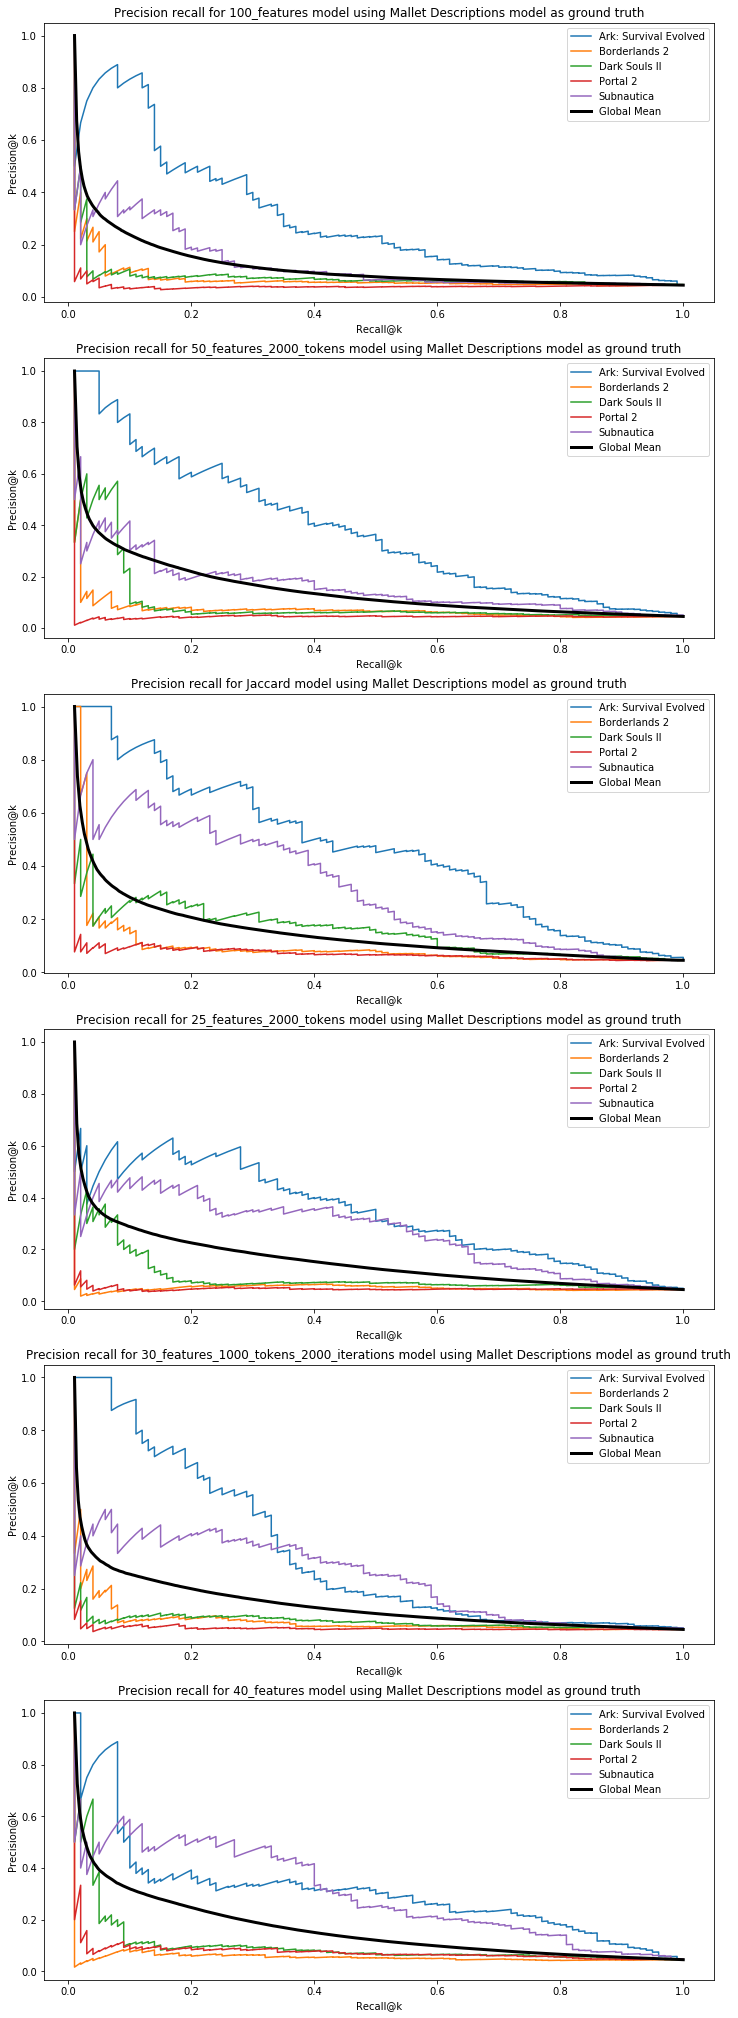

In [34]:
f, axes = plt.subplots(len(models), figsize=(12 ,6*len(models)))

model_PRs = {}

for axis, (model_name, model) in zip(axes, models.iteritems()):
    model_PRs[model_name] = plot_precision_recall(axis,
                                                  model, model_name,
                                                  descriptions_sim, "Mallet Descriptions")
plt.show()

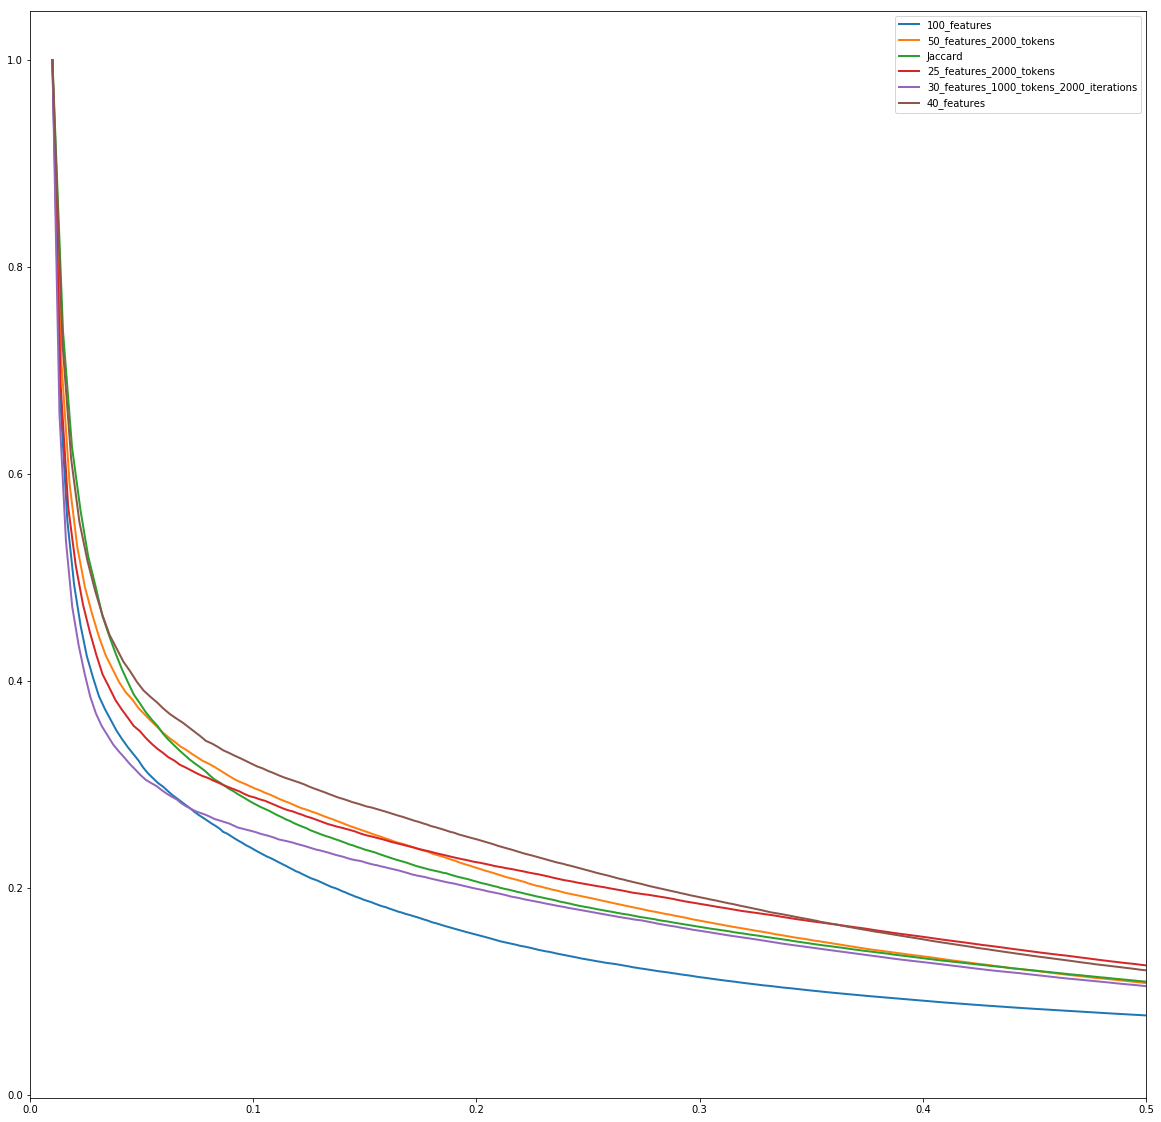

In [35]:
fig = plt.figure(figsize=(20, 20))
for model_name, (precision, recall) in model_PRs.iteritems():
    plt.plot(recall, precision, label=model_name, linewidth=2)
plt.xlim(0, 0.5)
plt.legend()
plt.show()